In [1]:
from pathlib import Path
import numpy as np
import h5py
from tqdm.auto import tqdm, trange
import scipy.io
import time
import torch
import random
import math
import shutil
from sklearn.decomposition import PCA
import scipy as sp
import scipy.signal

In [4]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

## Load Data

In [6]:
nyu_templates_path = '/Users/ankit/Documents/PaninskiLab/nyu47_templates/'
temp_file = 'kilosort_cleaned_templates.npy'
good_unit_file = 'good_units_kilosort.npy'

kilo_temps = np.load(nyu_templates_path + temp_file)
good_units = np.load(nyu_templates_path + good_unit_file)
kilo_good = kilo_temps[good_units]
bad_templates = np.array([207, 145, 99, 6, 141, 142, 220, 146, 178, 302, 177, 200, 139, 191, 181, 157, 182, 254])
kilo_temps = np.delete(kilo_temps, bad_templates, axis=0)

print(kilo_temps.shape)
print(good_units.shape)
print(good_units)

(290, 121, 384)
(62,)
[  1   3   4   5   8   9  10  11  14  17  19  24  25  26  27  30  31  32
  34  43  49  50  51  57  63  69  75  84  88  89  90  91  94  96  98 101
 102 104 111 112 116 120 125 128 129 136 159 161 162 163 166 171 229 233
 234 236 256 258 264 273 275 280]


In [7]:
mcs = np.array([np.abs(wf).max(0).argmax() for wf in kilo_temps])
align_ts = [np.abs(wf[:, mc]).argmax() for (wf, mc) in zip(kilo_temps, mcs)]
print(align_ts)

[42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,

In [13]:
unit_max_channels = np.array([np.argmax(np.max(template, axis=0) - np.min(template, axis=0)) for template in kilo_temps])
max_peak_inds = np.array([np.argmax(template, axis=0) for template in kilo_temps])
max_chan_templates = np.array([kilo_temps[i].T[unit_max_channels[i]] for i in range(len(unit_max_channels))])

In [14]:
ptps = np.array([np.max(template.max(0) - template.min(0)) for template in kilo_temps])
high_ptp_indices = np.array([i for i in range(len(kilo_temps)) if ptps[i] > 5])
high_ptp_temps = kilo_temps[high_ptp_indices]
max_chan_hptp_temps = max_chan_templates[high_ptp_indices]

## Numpy/Scipy Data Augmentations - model versions further down

In [15]:
def amp_jitter(max_chan_templates):
    templates = np.copy(max_chan_templates)
    n_templates, n_times = templates.shape

    chan_trough_times = np.array([np.argmin(template) for template in templates])
    trough_masked_temps = np.array([np.pad(templates[i, chan_trough_times[i]+1:-3], (chan_trough_times[i], 0), 'constant', constant_values=(-1000)) for i in range(n_templates)])
    chan_peak_times = np.array([np.argmax(temp) for temp in trough_masked_temps])

    scale_facs = np.random.uniform(0.9, 1.1, n_templates)
    scale_masks = []
    for i in range(len(templates)):
        scale_fac, trough_time, peak_time = scale_facs[i], chan_trough_times[i], chan_peak_times[i]
        # max_peak_windows.append(np.hstack(tuple(np.arange(trough_time-3, peak_time+3) for (trough_time, peak_time) in zip(trough_times, peak_times))))
        # make scaled mask for each channel in the current template
        scale_masks.append(np.pad(scale_fac * np.ones(peak_time-trough_time+7), (trough_time-3, n_times-peak_time-4), 'constant', constant_values=(1)))
    scale_masks = np.array(scale_masks)

    amp_jittered_templates = np.multiply(templates, scale_masks)
    
    return amp_jittered_templates

def amp_jitter_trough(max_chan_templates):
    templates = np.copy(max_chan_templates)
    n_templates, n_times = templates.shape

    chan_trough_times = np.array([np.argmin(template) for template in templates])

    scale_facs = np.random.uniform(0.9, 1.1, n_templates)
    scale_masks = []
    for i in range(len(templates)):
        scale_fac, trough_time = scale_facs[i], chan_trough_times[i]
        # make scaled mask for each channel in the current template
        scale_arr = np.pad(scale_fac * np.ones(9), (trough_time-4, n_times-trough_time-5), 'constant', constant_values=(1))
        scale_masks.append(scale_arr)
    scale_masks = np.array(scale_masks)

    amp_jittered_templates = np.multiply(templates, scale_masks)
    
    return amp_jittered_templates

def amp_whole_jitter(max_chan_templates):
    templates = np.copy(max_chan_templates)
    n_templates, n_times = templates.shape

    chan_trough_times = np.array([np.argmin(template) for template in templates])

    scale_facs = np.random.normal(1, 0.05, n_templates)
    scale_masks = np.ones(templates.shape)
    scale_masks = np.array([scale_facs[i]*scale_masks[i] for i in range(n_templates)])

    amp_jittered_templates = np.multiply(templates, scale_masks)
    
    return amp_jittered_templates


def jitter(max_chan_templates, up_factor=8):
    templates = np.copy(max_chan_templates)

    n_templates, n_times = max_chan_templates.shape

    # upsample best fit template
    up_temp = sp.signal.resample(
        x=max_chan_templates,
        num=n_times*up_factor,
        axis=1)
    up_temp = up_temp.T

    idx = (np.arange(0, n_times)[:,None]*up_factor + np.arange(up_factor))
    up_shifted_temps = up_temp[idx].transpose(2,0,1)
    up_shifted_temps = np.concatenate(
        (up_shifted_temps,
         np.roll(up_shifted_temps, shift=1, axis=1)),
        axis=2)
    templates = up_shifted_temps.transpose(0,2,1).reshape(-1, n_times)

    ref = np.mean(templates, 0)
    shifts = align_get_shifts_with_ref(
        templates, ref, upsample_factor=1)
    templates = shift_chans(templates, shifts)
#     n_templates, n_times = templates.shape

#     # upsample best fit template
#     up_temp = sp.signal.resample(
#         x=templates,
#         num=n_times*up_factor,
#         axis=1)
#     up_temp = up_temp.T

#     idx = (np.arange(0, n_times)[:,None]*up_factor + np.arange(up_factor))
#     up_shifted_temps = up_temp[idx].transpose(2,0,1)
#     up_shifted_temps = np.concatenate(
#         (up_shifted_temps,
#             np.roll(up_shifted_temps, shift=1, axis=1)),
#         axis=2)
#     templates = up_shifted_temps.transpose(0,2,1).reshape(-1, n_times)
    
#     ref = np.mean(templates, 0)
#     shifts = align_get_shifts_with_ref(
#         templates, ref, upsample_factor=1)
#     templates = shift_chans(templates, shifts)
    
    add_shifts = (2* np.random.binomial(1, 0.5, n_templates)-1) * np.random.uniform(0, 2, n_templates)
    idx_selection = np.random.choice(up_factor*2, n_templates)
    templates = templates[np.arange(n_templates)][idx_selection]
    templates = shift_chans(templates, add_shifts)
    print(templates.shape)
    
    return templates

def align_get_shifts_with_ref(wf, ref=None, upsample_factor=5, nshifts=7):

    ''' Align all waveforms on a single channel
    
        wf = selected waveform matrix (# spikes, # samples)
        max_channel: is the last channel provided in wf
        
        Returns: superresolution shifts required to align all waveforms
                 - used downstream for linear interpolation alignment
    '''
    # Cat: TODO: Peter's fix to clip/lengthen loaded waveforms to match reference templates    
    n_data, n_time = wf.shape

    if ref is None:
        ref = np.mean(wf, axis=0)

    #n_time_rf = len(ref)
    #if n_time > n_time_rf:
    #    left_cut = (n_time - n_time_rf)//2
    #    right_cut = n_time - n_time_rf - left_cut
    #    wf = wf[:, left_cut:-right_cut]
    #elif n_time < n_time_rf:
    #    left_buffer = np.zeros((n_data, (n_time_rf - n_time)//2))
    #    right_buffer = np.zeros((n_data,n_time_rf - n_time - left_buffer))
    #    wf = np.concatenate((left_buffer, wf, right_buffer), axis=1)
      
    # convert nshifts from timesamples to  #of times in upsample_factor
    nshifts = (nshifts*upsample_factor)
    if nshifts%2==0:
        nshifts+=1

    # or loop over every channel and parallelize each channel:
    #wf_up = []
    wf_up = upsample_resample(wf, upsample_factor)
    wlen = wf_up.shape[1]
    wf_start = nshifts//2
    wf_end = -nshifts//2
    
    wf_trunc = wf_up[:,wf_start:wf_end]
    wlen_trunc = wf_trunc.shape[1]
    
    # align to last channel which is largest amplitude channel appended
    ref_upsampled = upsample_resample(ref[np.newaxis], upsample_factor)[0]
    ref_shifted = np.zeros([wf_trunc.shape[1], nshifts])
    
    for i,s in enumerate(range(-(nshifts//2), (nshifts//2)+1)):
        ref_shifted[:,i] = ref_upsampled[s + wf_start: s + wf_end]

    bs_indices = np.matmul(wf_trunc[:,np.newaxis], ref_shifted).squeeze(1).argmax(1)
    best_shifts = (np.arange(-int((nshifts-1)/2), int((nshifts-1)/2+1)))[bs_indices]

    return best_shifts/np.float32(upsample_factor)

def upsample_resample(wf, upsample_factor):
    wf = wf.T
    waveform_len, n_spikes = wf.shape
    traces = np.zeros((n_spikes, (waveform_len-1)*upsample_factor+1),'float32')
    for j in range(wf.shape[1]):
        traces[j] = sp.signal.resample(wf[:,j],(waveform_len-1)*upsample_factor+1)
    return traces

def shift_chans(wf, best_shifts):
    # use template feat_channel shifts to interpolate shift of all spikes on all other chans
    wfs_final= np.zeros(wf.shape, 'float32')
    for k, shift_ in enumerate(best_shifts):
        int_shift = int(math.ceil(shift_)) if shift_ >= 0 else -int(math.floor(shift_))
        curr_wf_pos = np.pad(wf[k], (0, int_shift), 'constant') 
        curr_wf_neg = np.pad(wf[k], (int_shift, 0), 'constant')
        if int(shift_)==shift_:
            ceil = int(shift_)
            temp = np.roll(curr_wf_pos,ceil,axis=0)[:-int_shift] if shift_ > 0 else np.roll(curr_wf_neg,ceil,axis=0)[int_shift:]
        else:
            ceil = int(math.ceil(shift_))
            floor = int(math.floor(shift_))
            if shift_ > 0:
                temp = (np.roll(curr_wf_pos,ceil,axis=0)*(shift_-floor))[:-ceil] + (np.roll(curr_wf_pos,floor, axis=0)*(ceil-shift_))[:-ceil]
            else:
                temp = (np.roll(curr_wf_neg,ceil,axis=0)*(shift_-floor))[-floor:] + (np.roll(curr_wf_neg,floor, axis=0)*(ceil-shift_))[-floor:]
        wfs_final[k] = temp
    
    return wfs_final


def collide_templates(templates):
    max_chan_templates = np.copy(templates)
    n_templates, n_times = max_chan_templates.shape
    
    merge_temp_inds = np.random.choice(np.repeat(np.arange(n_templates), 10), n_templates, replace=True)
    for i in range(len(merge_temp_inds)):
        while merge_temp_inds[i] == i:
            merge_temp_inds[i] = np.random.choice(np.arange(n_templates), 1)
    merge_temps = max_chan_templates[merge_temp_inds]
    merge_temps_peak_inds = np.array([np.argmax(template, axis=0) for template in merge_temps])
    
    temp_scale_fac = np.random.uniform(0.2, 1, n_templates)
    temp_offsets = (2* np.random.binomial(1, 0.5, n_templates)-1) * np.random.randint(5, 60, n_templates)
    
    offset_merge_temps = shift_chans(merge_temps, temp_offsets)
    scaled_offset_temps = np.array([np.multiply(scale, temp) for (scale, temp) in zip(temp_scale_fac, offset_merge_temps)])
    collided_temps = np.add(max_chan_templates, scaled_offset_temps)

    return collided_temps, scaled_offset_temps

def noisify(max_chan_templates):
    templates = np.copy(max_chan_templates)
    n_templates, n_times = templates.shape
    
    noise = np.random.normal(0, 1, templates.shape)
    templates = np.add(templates, noise)
    return templates

# def noise_wfs(recordings, temporal_size, window_size, sample_size=1000,
#               threshold=3.0, max_trials_per_sample=100,
#               allow_smaller_sample_size=False):
#     """Compute noise temporal and spatial covariance
#     Parameters
#     ----------
#     recordings: numpy.ndarray
#         Recordings
#     temporal_size:
#         Waveform size
#     sample_size: int
#         Number of noise snippets of temporal_size to search
#     threshold: float
#         Observations below this number are considered noise
#     Returns
#     -------
#     spatial_SIG: numpy.ndarray
#     temporal_SIG: numpy.ndarray
#     """
#     # logger = logging.getLogger(__name__)

#     # kill signal above threshold in recordings
#     print('Get Noise Floor')
#     rec, is_noise_idx = kill_signal(recordings, threshold, window_size)

# #     # compute spatial covariance, output: (n_channels, n_channels)
# #     print('Compute Spatial Covariance')
# #     spatial_cov = np.divide(np.matmul(np.transpose(rec, (0, 2, 1)), rec),
# #                             np.matmul(np.transpose(is_noise_idx, (0, 2, 1)), is_noise_idx))

# #     spatial_cov[np.isnan(spatial_cov)] = 0
# #     spatial_cov[np.isinf(spatial_cov)] = 0
# #     # print(np.isnan(spatial_cov))

# #     # compute spatial sig
# #     w_spatial, v_spatial = np.linalg.eig(spatial_cov)
# #     diag_mat_spatial = np.array([np.diag(1/np.sqrt(w)) for w in w_spatial])
# #     diag_mat_whitener = np.array([np.diag(np.sqrt(w)) for w in w_spatial])
# #     spatial_SIG = np.matmul(np.matmul(v_spatial,
# #                                       diag_mat_spatial),
# #                             np.transpose(v_spatial, (0, 2, 1)))

# #     # apply spatial whitening to recordings
# #     print('Compute Temporal Covariance')
# #     spatial_whitener = np.matmul(np.matmul(v_spatial, diag_mat_whitener),
# #                                  np.transpose(v_spatial, (0, 2, 1)))
#     # rec = np.matmul(rec, spatial_whitener)
    

#     # search single noise channel snippets
#     noise_wf = search_noise_snippets(
#         recordings, is_noise_idx, sample_size,
#         temporal_size,
#         channel_choices=None,
#         max_trials_per_sample=max_trials_per_sample,
#         allow_smaller_sample_size=allow_smaller_sample_size)

#     return noise_wf


# def kill_signal(recordings, threshold, window_size):
#     """
#     Thresholds recordings, values above 'threshold' are considered signal
#     (set to 0), a window of size 'window_size' is drawn around the signal
#     points and those observations are also killed
#     Returns
#     -------
#     recordings: numpy.ndarray
#         The modified recordings with values above the threshold set to 0
#     is_noise_idx: numpy.ndarray
#         A boolean array with the same shap as 'recordings' indicating if the
#         observation is noise (1) or was killed (0).
#     """
#     new_recordings = np.copy(recordings)

#     n_templates, T, C = new_recordings.shape
#     R = int((window_size-1)/2)

#     # this will hold a flag 1 (noise), 0 (signal) for every obseration in the
#     # recordings
#     is_noise_idx = np.zeros(new_recordings.shape)

#     # go through every neighboring channel on every cluster
#     for t in range(n_templates):
#         for c in range(C):

#             # get observations where observation is above threshold
#             idx_temp = np.where(np.abs(new_recordings[t, :, c]) > threshold)[0]

#             # shift every index found
#             for j in range(-R, R+1):

#                 # shift
#                 idx_temp2 = idx_temp + j
                

#                 # remove indexes outside range [0, T]
#                 idx_temp2 = idx_temp2[np.logical_and(idx_temp2 >= 0,
#                                                      idx_temp2 < T)]

#                 # set surviving indexes to nan
#                 new_recordings[t, idx_temp2, c] = np.nan

#             # noise indexes are the ones that are not nan
#             # FIXME: compare to np.nan instead
#             is_noise_idx_temp = (new_recordings[t, :, c] == recordings[t, :, c])
#             if is_noise_idx_temp.shape[0] != 121:
#                 print(is_noise_idx_temp.shape)
                
#             if np.isnan(np.nanstd(new_recordings[t, :, c])) or np.nanstd(new_recordings[t, :, c]) == 0:
#                 # print(new_recordings[t, :, c])
#                 std_dev = 10**-5
#             else: 
#                 std_dev = np.nanstd(new_recordings[t, :, c])

#             # standarize data, ignoring nans
#             new_recordings[t, :, c] = recordings[t, :, c]/std_dev

#             # set non noise indexes to 0 in the recordings
#             new_recordings[t, ~is_noise_idx_temp, c] = 10**-7

#             # save noise indexes
#             is_noise_idx[t, is_noise_idx_temp, c] = 1

#     return new_recordings, is_noise_idx


# def search_noise_snippets(recordings, is_noise_idx, sample_size,
#                           temporal_size, channel_choices=None,
#                           max_trials_per_sample=1000,
#                           allow_smaller_sample_size=True):
#     """
#     Randomly search noise snippets of 'temporal_size'
#     Parameters
#     ----------
#     channel_choices: list
#         List of sets of channels to select at random on each trial
#     max_trials_per_sample: int, optional
#         Maximum random trials per sample
#     allow_smaller_sample_size: bool, optional
#         If 'max_trials_per_sample' is reached and this is True, the noise
#         snippets found up to that time are returned
#     Raises
#     ------
#     ValueError
#         if after 'max_trials_per_sample' trials, no noise snippet has been
#         found this exception is raised
#     Notes
#     -----
#     Channels selected at random using the random module from the standard
#     library (not using np.random)
#     """

#     n_templates, T, C = recordings.shape

#     if channel_choices is None:
#         noise_wf = np.zeros((sample_size, temporal_size))
#     else:
#         lenghts = set([len(ch) for ch in channel_choices])

#         if len(lenghts) > 1:
#             raise ValueError('All elements in channel_choices must have '
#                              'the same length, got {}'.format(lenghts))

#         n_channels = len(channel_choices[0])
#         noise_wf = np.zeros((sample_size, temporal_size, n_channels))

#     count = 0

#     # logger.debug('Starting to search noise snippets...')

#     trial = 0

#     # repeat until you get sample_size noise snippets
#     while count < sample_size:

#         # random number for the start of the noise snippet
#         # t_start = np.random.randint(T-temporal_size)
#         t_start = 0

#         if channel_choices is None:
#             # random channel
#             temp = random.randint(0, n_templates-1)
#             ch = random.randint(0, C - 1)
#         else:
#             temp = random.randint(0, n_templates-1)
#             ch = random.choice(channel_choices)

#         t_slice = slice(t_start, t_start+temporal_size)

#         # get a snippet from the recordings and the noise flags for the same
#         # location
#         snippet = recordings[temp, t_slice, ch]
#         snipped_idx_noise = is_noise_idx[temp, t_slice, ch]

#         # check if all observations in snippet are noise
#         if snipped_idx_noise.all():
#             # add the snippet and increase count
#             noise_wf[count] = snippet
#             count += 1
#             trial = 0

#             # logger.debug('Found %i/%i...', count, sample_size)

#         trial += 1

#         if trial == max_trials_per_sample:
#             if allow_smaller_sample_size:
#                 return noise_wf[:count]
#             else:
#                 raise ValueError("Couldn't find snippet {} of size {} after "
#                                  "{} iterations (only {} found)"
#                                  .format(count + 1, temporal_size,
#                                          max_trials_per_sample,
#                                          count))

#     return noise_wf

# def smart_noisify(templates, max_chan_templates, noise_thresh=3.0):
#     noise_wf = noise_wfs(templates, 121, 20, threshold=noise_thresh, max_trials_per_sample=1000000)
    
#     noise_selections = np.random.randint(0, len(noise_wf), len(max_chan_templates))
    
#     noise_2_add = noise_wf[noise_selections]
#     noisy_templates = np.add(max_chan_templates, noise_2_add)
    
#     return noisy_templates


def smart_noisify2(max_chan_templates):
    temp_cov = np.load('temporal_cov_example.npy')
    n_templates, n_times = max_chan_templates.shape
    
    noise_2_add = np.random.multivariate_normal(np.zeros(n_times), temp_cov, n_templates)
    noisy_templates = np.add(max_chan_templates, noise_2_add)
    
    return noisy_templates



### plotting for numpy/scipy augs

In [16]:
def plot(templates, aug_temps, temp_choice):
    curr_templates = [templates[temp_choice], aug_temps[temp_choice]]
    max_chan_max = np.max(curr_templates[0])
    max_chan_min = np.min(curr_templates[0])

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

    for i in range(2):
        x = np.arange(0, len(curr_template[0]))
        ax[i].title.set_text('unit ' + str(temp_choice))
        ax[i].plot(x, curr_template[i], linewidth=2, markersize=12)
        if i == 0:
            ax[i].set_ylim(max_chan_min-0.5, max_chan_max+0.5)

    # fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)

    
def plot_overlap(denoised_temps, aug_temps, temp_choice, aug_title, collided_temps=None):
    curr_templates = [denoised_temps[temp_choice], aug_temps[temp_choice]]
    if collided_temps is not None:
        curr_templates.append(collided_temps[temp_choice])
    max_chan_max = max(np.max(curr_templates[1]), np.max(curr_templates[0]))
    max_chan_min = min(np.min(curr_templates[1]), np.min(curr_templates[0]))
    colors = ['blue', 'red', 'green']
    
    plot_length = len(curr_templates) + 1

    fig, ax = plt.subplots(1, plot_length, sharey=True, figsize=(plot_length*2, 3))

    for i in range(plot_length):
        x = np.arange(0, len(curr_templates[0]))
        if i == 0:
            ax[i].set_ylim(max_chan_min-0.5, max_chan_max+0.5)
            ax[i].title.set_text('unit ' + str(temp_choice))
        elif i == 1:
            ax[i].title.set_text(aug_title + ' wf')
        elif i == 2:
            ax[i].title.set_text('overlaid wfs')
            ax[i].plot(x, curr_templates[0], linewidth=2, color=colors[0])
            ax[i].plot(x, curr_templates[1], linewidth=2, color=colors[1], alpha=0.5)
            continue
        elif i == 3:
            ax[i].title.set_text('uncollided wfs')
            ax[i].plot(x, curr_templates[0], linewidth=2, color=colors[0])
            ax[i].plot(x, curr_templates[2], linewidth=2, color=colors[2])
            continue
        ax[i].plot(x, curr_templates[i], linewidth=2, markersize=12, color=colors[i])

    # fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    
    
def plot_overlap_new(base_temp, aug_temp):
    curr_templates = [base_temp, aug_temp]
    max_chan_max = max(np.max(curr_templates[1]), np.max(curr_templates[0]))
    max_chan_min = min(np.min(curr_templates[1]), np.min(curr_templates[0]))
    colors = ['blue', 'red', 'green']
    
    plot_length = len(curr_templates) + 1

    fig, ax = plt.subplots(1, plot_length, sharey=True, figsize=(plot_length*2, 3))

    for i in range(plot_length):
        x = np.arange(0, len(curr_templates[0]))
        if i == 0:
            ax[i].set_ylim(max_chan_min-0.5, max_chan_max+0.5)
        # elif i == 1:
        #     ax[i].title.set_text(aug_title + ' wf')
        elif i == 2:
            ax[i].title.set_text('overlaid wfs')
            ax[i].plot(x, curr_templates[0], linewidth=2, color=colors[0])
            ax[i].plot(x, curr_templates[1], linewidth=2, color=colors[1], alpha=0.5)
            continue
        ax[i].plot(x, curr_templates[i], linewidth=2, markersize=12, color=colors[i])

    # fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    
    
def mega_plot(templates_set, aug_titles, temp_choice, save_name=None):
    n_sets = len(templates_set)
    n_templates, n_times = templates_set[0].shape
    temp_set_choice = np.array([temp_set[temp_choice] for temp_set in templates_set])
    
    max_chan_max = max([np.max(temp) for temp in temp_set_choice])
    max_chan_min = min([np.min(temp) for temp in temp_set_choice])
    colors = ['blue', 'red', 'green']
    
    plot_length = 4
    fig, ax = plt.subplots(n_sets-2, plot_length, sharey=True, figsize=(plot_length*2, 3*(n_sets-2)))
    
    for row in range(n_sets-2):
        
        x = np.arange(0, n_times)
        ax[row, 0].set_ylim(max_chan_min-0.5, max_chan_max+0.5)
        ax[row, 0].title.set_text('unit ' + str(temp_choice))
        ax[row, 0].plot(x, temp_set_choice[0], linewidth=2, markersize=12, color=colors[0])

        ax[row, 1].title.set_text(aug_titles[row] + ' wf')
        ax[row, 1].plot(x, temp_set_choice[row+1], linewidth=2, markersize=12, color=colors[1])

        ax[row, 2].title.set_text('overlaid wfs')
        ax[row, 2].plot(x, temp_set_choice[0], linewidth=2, color=colors[0])
        ax[row, 2].plot(x, temp_set_choice[row+1], linewidth=2, markersize=12, color=colors[1], alpha=0.5)

        if row == n_sets-3:
            ax[row, 3].title.set_text('uncollided wfs')
            ax[row, 3].plot(x, temp_set_choice[0], linewidth=2, color=colors[0])
            ax[row, 3].plot(x, temp_set_choice[-1], linewidth=2, color=colors[2])
        else:
            fig.delaxes(ax[row, 3])
    
    fig.subplots_adjust(wspace=0)
    
    if save_name is not None:
        plt.savefig(save_name)

    
def plot_transforms(max_chan_temps, aug_temps, probs, save_name=None):
    n_sets = len(aug_temps)
    n_templates, n_times = templates_set[0].shape
    max_chan_temps = max_chan_temps[:n_sets]
    aug_temp_mod = aug_temps.reshape(-1)
    aug_temp_mod = np.array([aug_temp.numpy() for aug_temp in aug_temp_mod])
    tot_temps = np.vstack((max_chan_temps, aug_temp_mod))
    print(tot_temps.shape)
    
    max_chan_max = [max(np.max(max_chan_temps[i//2]), np.max(aug_temp_mod[i]), np.max(aug_temp_mod[i+1])) for i in range(0, len(aug_temp_mod), 2)]
    max_chan_min = [min(np.min(max_chan_temps[i//2]), np.min(aug_temp_mod[i]), np.min(aug_temp_mod[i+1])) for i in range(0, len(aug_temp_mod), 2)]
    # max_chan_max = max([np.max(temp) for temp in tot_temps])
    # max_chan_min = min([np.min(temp) for temp in tot_temps])
    colors = ['blue', 'red', 'green']
    
    plot_length = 5
    fig, ax = plt.subplots(n_sets, plot_length, sharey='row', figsize=(plot_length*2, 3*(n_sets-2)))
    
    for row in range(n_sets):
        
        zero_title = 'unit {}, p = {}'.format(str(row), str(probs)) if row == 0 else 'unit {}'.format(str(row))
        
        x = np.arange(0, n_times)
        # print(max_chan_min[row] + ' ')
        # print(max_chan_max[row])
        ax[row, 0].set_ylim(max_chan_min[row]-0.5, max_chan_max[row]+0.5)
        ax[row, 0].title.set_text(zero_title)
        ax[row, 0].plot(x, max_chan_temps[row], linewidth=2, markersize=12, color=colors[0])
        ax[row, 0].get_xaxis().set_visible(False)

        ax[row, 1].title.set_text('view 1')
        ax[row, 1].plot(x, aug_temps[row][0].numpy(), linewidth=2, markersize=12, color=colors[1])
        ax[row, 1].get_xaxis().set_visible(False)
        
        ax[row, 2].title.set_text('view 2')
        ax[row, 2].plot(x, aug_temps[row][1].numpy(), linewidth=2, markersize=12, color=colors[2])
        ax[row, 2].get_xaxis().set_visible(False)

        ax[row, 3].title.set_text('overlaid view 1')
        ax[row, 3].plot(x, max_chan_temps[row], linewidth=2, color=colors[0])
        ax[row, 3].plot(x, aug_temps[row][0].numpy(), linewidth=2, markersize=12, color=colors[1], alpha=0.5)
        ax[row, 3].get_xaxis().set_visible(False)

        ax[row, 4].title.set_text('overlaid view 2')
        ax[row, 4].plot(x, max_chan_temps[row], linewidth=2, color=colors[0])
        ax[row, 4].plot(x, aug_temps[row][1].numpy(), linewidth=2, markersize=12, color=colors[2], alpha=0.5)
        ax[row, 4].get_xaxis().set_visible(False)
    
    fig.subplots_adjust(wspace=0)
    
    if save_name is not None:
        plt.savefig(save_name)
        
        
def plot_spikes(max_chan_spikes, wf_interest, wf_temps, save_name=None):
    num_sel_spikes = 5
    num_temps, tot_spikes, n_times = max_chan_spikes.shape
    sels = np.random.choice(tot_spikes, (num_temps, num_sel_spikes))
    print(sels)
    
    sel_spikes = np.array([max_chan_spikes[i, sels[i], :] for i in range(num_temps)])
    
    max_chan_max = [np.max([np.max(sel_spikes[i][j] for j in range(num_sel_spikes))]) for i in range(num_temps)]
    print(max_chan_max)
    max_chan_min = [np.min([np.min(sel_spikes[i][j] for j in range(num_sel_spikes))]) for i in range(num_temps)]
    # max_chan_max = max([np.max(temp) for temp in tot_temps])
    # max_chan_min = min([np.min(temp) for temp in tot_temps])
    # colors = ['blue', 'red', 'green']
    
    fig, ax = plt.subplots(num_temps, num_sel_spikes + 1, sharey='row', figsize=((num_sel_spikes+1)*2, 3*(num_temps-2)))
    
    for row in range(num_temps):
        
        zero_title = 'unit {}'.format(str(wf_interest[row]))
        
        x = np.arange(0, n_times)
        ax[row, 0].title.set_text(zero_title)
        ax[row, 0].plot(x, wf_temps[wf_interest[row]], linewidth=2, markersize=12, color='red')
        ax[row, 0].get_xaxis().set_visible(False)
        
        # print(max_chan_min[row] + ' ')
        # print(max_chan_max[row])
        # ax[row, 0].set_ylim(max_chan_min[row]-0.5, max_chan_max[row]+0.5)
        ax[row, 1].plot(x, sel_spikes[row][0], linewidth=2, markersize=12, color='red')
        ax[row, 1].get_xaxis().set_visible(False)

        # ax[row, 1].title.set_text('view 1')
        ax[row, 2].plot(x, sel_spikes[row][1], linewidth=2, markersize=12, color='red')
        ax[row, 2].get_xaxis().set_visible(False)
        
        # ax[row, 2].title.set_text('view 2')
        ax[row, 3].plot(x, sel_spikes[row][2], linewidth=2, markersize=12, color='red')
        ax[row, 3].get_xaxis().set_visible(False)

        # ax[row, 3].title.set_text('overlaid view 1')
        ax[row, 4].plot(x, sel_spikes[row][3], linewidth=2, markersize=12, color='red')
        ax[row, 4].get_xaxis().set_visible(False)

        # ax[row, 4].title.set_text('overlaid view 2')
        ax[row, 5].plot(x, sel_spikes[row][4], linewidth=2, markersize=12, color='red')
        ax[row, 5].get_xaxis().set_visible(False)
    
    fig.subplots_adjust(wspace=0)
    fig.subplots_adjust(hspace=0.25)
    
    if save_name is not None:
        plt.savefig(save_name)

In [17]:
# amp_jittered_temps = amp_jitter(max_chan_templates)
# amp_t_jittered_temps = amp_jitter_trough(max_chan_templates)

# get augmented version of templates for each augmentation (# wfs, wf template length)
amp_whole_jittered_temps = amp_whole_jitter(max_chan_templates)
jittered_temps = jitter(max_chan_templates)
collided_temps, offset_temps = collide_templates(max_chan_templates)
noisy_temps = noisify(max_chan_templates)
smart_noisy_temps = smart_noisify2(max_chan_templates)

(290, 121)


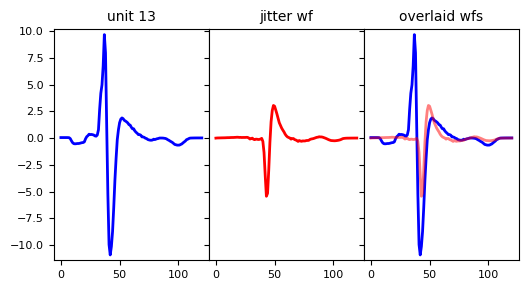

In [18]:
plot_overlap(max_chan_templates, jittered_temps, 13, 'jitter')

In [19]:
# amp_jittered_temps = amp_jitter(max_chan_templates)
# amp_t_jittered_temps = amp_jitter_trough(max_chan_templates)

# get augmented version of hight ptp templates for each augmentation (# wfs, wf template length)
amp_whole_jittered_hptp = amp_whole_jitter(max_chan_hptp_temps)
jittered_hptp = jitter(max_chan_hptp_temps)
collided_hptp, offset_hptp = collide_templates(max_chan_hptp_temps)
noisy_hptp = noisify(max_chan_hptp_temps)
smart_noisy_hptp = smart_noisify2(max_chan_hptp_temps)

(263, 121)


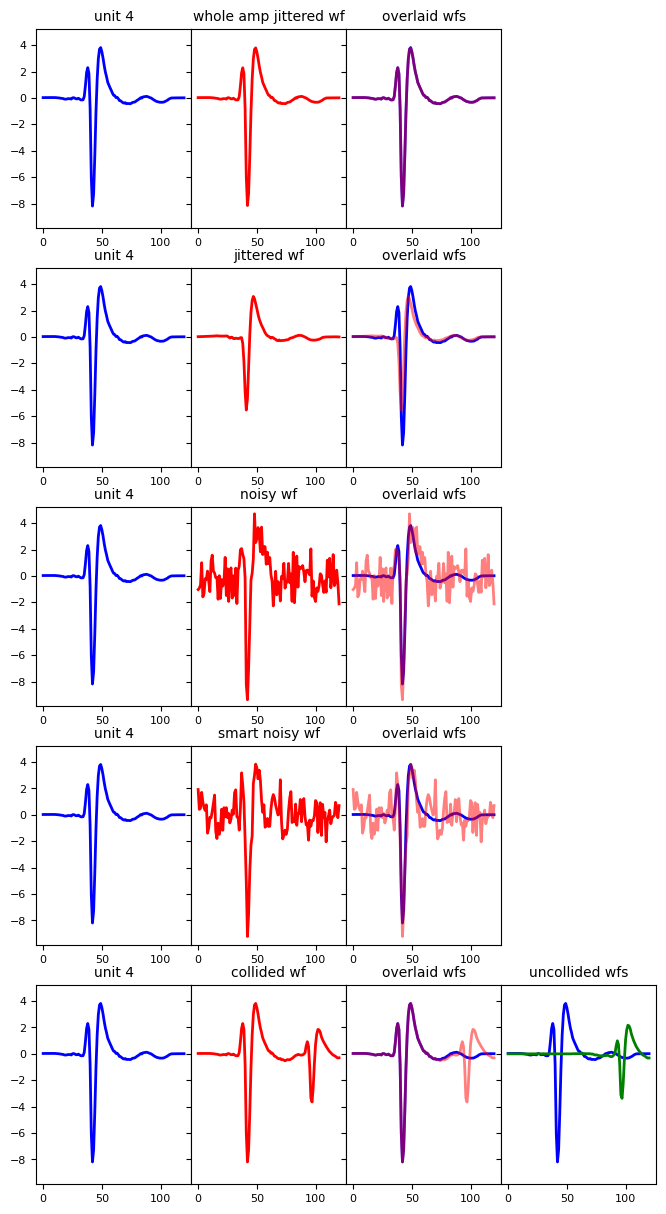

In [23]:
templates_set_hptp = [max_chan_hptp_temps, amp_whole_jittered_hptp, jittered_hptp, noisy_hptp, smart_noisy_hptp, collided_hptp, offset_hptp]
titles_set = ['whole amp jittered', 'jittered', 'noisy', 'smart noisy', 'collided']
temp_choice = 4

mega_plot(templates_set_hptp, titles_set, temp_choice)

# Pytorch Implementations

### Data Augmentations

In [24]:
from __future__ import print_function, division
from array import array
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import h5py
import random
import scipy as sp
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.distributions.transforms import Transform
from torch.distributions.uniform import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.bernoulli import Bernoulli
from torchaudio.transforms import Resample

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


class AmpJitter(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __call__(self, sample):
        wf = sample
        w = wf.shape[0]

        uni = Uniform(torch.tensor([0.9]), torch.tensor([1.1]))
        amp_jit = uni.sample()

        wf = torch.multiply(wf, amp_jit)
    
        return wf.double()

class Noise(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __call__(self, sample):
        wf = sample
        w = wf.shape[0]

        mvn = MultivariateNormal(torch.zeros(w), torch.eye(w))
        noise_wf = mvn.sample()
        wf = wf + noise_wf

        return wf

class SmartNoise(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    root_folder = '/Users/ankit/Documents/PaninskiLab/spike-psvae/notebook'
    cov_name = 'temporal_cov_example.npy'

    def __init__(self, temporal_cov=None):
        if temporal_cov is None:
            temporal_cov = np.load(self.root_folder + self.cov_name)
        # assert isinstance(temporal_cov, (float, array))
        self.temporal_cov = torch.from_numpy(temporal_cov).double()

    def __call__(self, sample):
        # wf = sample['wf']
        wf = sample
        w = wf.shape[0]

        assert self.temporal_cov.shape[0] == w

        mvn = MultivariateNormal(torch.zeros(w).double(), self.temporal_cov.double())
        noise_wf = mvn.sample()
        wf = wf + noise_wf

        return wf

class Collide(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    root_folder = '/Users/ankit/Documents/PaninskiLab/nyu47_templates/'
    temp_name = 'kilo_hptp_mcs.npy'

    def __init__(self, templates=None):
        if templates is None:
            templates = np.load(self.root_folder+self.temp_name)
        # assert isinstance(templates, (array, array))
        self.templates = templates

    def __call__(self, sample):
        wf = sample
        w = wf.shape[0]

        temp_idx = torch.randint(0, len(self.templates), (1,))
        temp_sel = torch.from_numpy(self.templates[temp_idx])

        scale = Uniform(torch.tensor([0.2]), torch.tensor([1.0])).sample()
        offset = torch.randint(5, 60, (1,))
        shift = (torch.multiply(torch.tensor([2.0]), Bernoulli(torch.tensor([0.5])).sample()) - torch.tensor([1.0])).multiply(offset)

        temp_sel = temp_sel.multiply(scale)
        temp_sel = self.shift_chans(temp_sel, shift)

        wf = wf.add(temp_sel)

        return wf

    def shift_chans(wf, shift):
        # use template feat_channel shifts to interpolate shift of all spikes on all other chans
        int_shift = torch.ceil(shift) if shift.item() >= 0 else torch.floor(shift).multiply(-1)
        int_shift = int(int_shift.view())
        curr_wf_pos = F.pad(wf, (0, int_shift), 'constant') 
        curr_wf_neg = F.pad(wf, (int_shift, 0), 'constant')

        if shift > 0:
            wf_final = torch.roll(curr_wf_pos,int_shift,axis=0)[:-int_shift]
        else:
            wf_final = torch.roll(curr_wf_neg,int_shift,axis=0)[int_shift:]
        
        return wf_final

class Jitter(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, templates=None, up_factor=8, sample_rate=20000):
        # assert isinstance(templates, (array, array))
        assert isinstance(up_factor, (int))
        assert isinstance(sample_rate, (int))
        self.templates = templates
        self.up_factor = up_factor
        self.sample_rate = sample_rate

    def __call__(self, sample):
        wf = sample
        w = wf.shape[0]

        resample = Resample(self.sample_rate, self.up_factor * self.sample_rate)
        wf_upsamp = resample(wf.double()).t()

        # temp_idx = torch.randint(0, len(self.templates), (1,))
        # temp_sel = self.templates[temp_idx]

        idx = torch.arange(0, self.up_factor*w).reshape(-1, self.up_factor)
        up_shifted_wfs = wf_upsamp[idx]
        # up_shifted_temps.unsqueeze(1)
        # up_shifted_temps = torch.cat(
        #     (up_shifted_temps,temp_sel),
        #     axis=1)
        
        offset = torch.randint(0, 3, (1,))
        shift = (torch.multiply(torch.tensor([2.0]), Bernoulli(torch.tensor([0.5])).sample()) - torch.tensor([1.0])).multiply(offset)

        idx_selection = torch.randint(self.up_factor)
        wf = up_shifted_wfs[idx_selection]
        wf = self.shift_chans(wf, shift)

        return wf

    def shift_chans(wf, shift):
        # use template feat_channel shifts to interpolate shift of all spikes on all other chans
        int_shift = torch.ceil(shift) if shift.item() >= 0 else torch.floor(shift).multiply(-1)
        int_shift = int(int_shift.view())
        curr_wf_pos = F.pad(wf, (0, int_shift), 'constant') 
        curr_wf_neg = F.pad(wf, (int_shift, 0), 'constant')

        if shift > 0:
            wf_final = torch.roll(curr_wf_pos,int_shift,axis=0)[:-int_shift]
        else:
            wf_final = torch.roll(curr_wf_neg,int_shift,axis=0)[int_shift:]
        
        return wf_final
    
    # def shift_chans(wfs, shifts):
    #     wfs_final= torch.zeros(wfs.size(), dtype=torch.float32)

    #     for k, shift in enumerate(shifts):
    #         wf = wf[k]
    #         # use template feat_channel shifts to interpolate shift of all spikes on all other chans
    #         int_shift = torch.ceil(shift) if shift.item() >= 0 else torch.floor(shift).multiply(-1)
    #         int_shift = int(int_shift.view())
    #         curr_wf_pos = F.pad(wf, (0, int_shift), 'constant') 
    #         curr_wf_neg = F.pad(wf, (int_shift, 0), 'constant')

    #         if shift > 0:
    #             wfs_final[k] = torch.roll(curr_wf_pos,int_shift,axis=0)[:-int_shift]
    #         else:
    #             wfs_final[k] = torch.roll(curr_wf_neg,int_shift,axis=0)[int_shift:]
        
    #     return wfs_final



In [87]:
from __future__ import print_function, division
from array import array
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import h5py
import random
import scipy as sp
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.distributions.transforms import Transform
from torch.distributions.uniform import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.bernoulli import Bernoulli
from torchaudio.transforms import Resample

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


class AmpJitter(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __call__(self, sample):
        wf = sample
        w = wf.shape[0]

        # uni = Uniform(torch.tensor([0.9]), torch.tensor([1.1]))
        # amp_jit = uni.sample()

        # wf = torch.multiply(wf, amp_jit)
        
        amp_jit = np.random.uniform(0.9, 1.1)
        wf = amp_jit * wf
    
        return wf

class Noise(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __call__(self, sample):
        wf = sample
        w = wf.shape[0]

        # mvn = MultivariateNormal(torch.zeros(w), torch.eye(w))
        # noise_wf = mvn.sample()
        # wf = wf + noise_wf
        
        noise_wf = np.random.normal(0, 1, w)
        wf = np.add(wf, noise_wf)

        return wf

# Actual noise function used
class SmartNoise(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    root_folder = '/Users/ankit/Documents/PaninskiLab/spike-psvae/notebook/'
    temporal_name = 'temporal_cov_example.npy'
    spatial_name = 'spatial_cov_example.npy'

    def __init__(self, temporal_cov=None, spatial_cov=None):
        if temporal_cov is None:
            temporal_cov = np.load(self.root_folder + self.temporal_name)
        if spatial_cov is None:
            spatial_cov = np.load(self.root_folder + self.spatial_name)
        self.temporal_cov = temporal_cov
        self.spatial_cov = spatial_cov
        # assert isinstance(temporal_cov, (float, array))
        # self.temporal_cov = torch.from_numpy(temporal_cov).double()

    def __call__(self, sample):
        wf = sample
        w = wf.shape[0]

        assert self.temporal_cov.shape[0] == w
        
        # Uses temporal and spatial covariance to create more realistic noise on the channel
        n_neigh, _ = self.spatial_cov.shape
        waveform_length, _ = self.temporal_cov.shape

        noise = np.random.normal(size=(waveform_length, n_neigh))

        for c in range(n_neigh):
            noise[:, c] = np.matmul(noise[:, c], self.temporal_cov)
            reshaped_noise = np.reshape(noise, (-1, n_neigh))

        the_noise = np.reshape(np.matmul(reshaped_noise, self.spatial_cov),
                           (waveform_length, n_neigh))

        noise_sel = np.random.choice(n_neigh)
        noise_wf = the_noise[:, noise_sel]
        wf = np.add(wf, noise_wf)

        return wf

class Collide(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    root_folder = '/Users/ankit/Documents/PaninskiLab/nyu47_templates/'
    temp_name = 'kilo_hptp_mcs.npy'

    def __init__(self, templates=None):
        if templates is None:
            templates = np.load(self.root_folder+self.temp_name)
        # assert isinstance(templates, (array, array))
        self.templates = templates

    def __call__(self, sample):
        wf = sample
        w = wf.shape[0]

        # Select a random template and add a scaled version to the current template, offset by some amount
        temp_idx = np.random.randint(0, len(self.templates))
        temp_sel = self.templates[temp_idx]
        
        scale = np.random.uniform(0.2, 1)
        shift = (2* np.random.binomial(1, 0.5)-1) * np.random.randint(5, 60)

        temp_sel = temp_sel * scale
        temp_sel = self.shift_chans(temp_sel, shift)

        wf = wf + temp_sel

        return wf

    def shift_chans(self, wf, shift_):
        # use template feat_channel shifts to interpolate shift of all spikes on all other chans
        int_shift = int(math.ceil(shift_)) if shift_ >= 0 else -int(math.floor(shift_))
        curr_wf_pos = np.pad(wf, (0, int_shift), 'constant') 
        curr_wf_neg = np.pad(wf, (int_shift, 0), 'constant')
        if int(shift_)==shift_:
            ceil = int(shift_)
            temp = np.roll(curr_wf_pos,ceil,axis=0)[:-int_shift] if shift_ > 0 else np.roll(curr_wf_neg,ceil,axis=0)[int_shift:]
        else:
            ceil = int(math.ceil(shift_))
            floor = int(math.floor(shift_))
            if shift_ > 0:
                temp = (np.roll(curr_wf_pos,ceil,axis=0)*(shift_-floor))[:-ceil] + (np.roll(curr_wf_pos,floor, axis=0)*(ceil-shift_))[:-ceil]
            else:
                temp = (np.roll(curr_wf_neg,ceil,axis=0)*(shift_-floor))[-floor:] + (np.roll(curr_wf_neg,floor, axis=0)*(ceil-shift_))[-floor:]
        wf_final = temp

        return wf_final

    
class Jitter(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, templates=None, up_factor=8, sample_rate=20000):
        # assert isinstance(templates, (array, array))
        assert isinstance(up_factor, (int))
        assert isinstance(sample_rate, (int))
        self.templates = templates
        self.up_factor = up_factor
        self.sample_rate = sample_rate

    def __call__(self, sample):
        wf = sample
        w = wf.shape[0]

        # Perform upsampling and take a version of the upsampled template as the jittered version
        
        resample = sp.signal.resample(
            x=wf,
            num=w*self.up_factor,
            axis=0)
        up_temp = resample.T
        
        idx = (np.arange(0, w)[:,None]*self.up_factor + np.arange(self.up_factor))
        up_shifted_temp = up_temp[idx].T

        shift = (2* np.random.binomial(1, 0.5)-1) * np.random.uniform(0, 2)
        
        idx_selection = np.random.choice(self.up_factor)
        wf = up_shifted_temp[idx_selection]
        wf = self.shift_chans(wf, shift)

        return wf

    def shift_chans(self, wf, shift_):
        # use template feat_channel shifts to interpolate shift of all spikes on all other chans
        int_shift = int(math.ceil(shift_)) if shift_ >= 0 else -int(math.floor(shift_))
        curr_wf_pos = np.pad(wf, (0, int_shift), 'constant') 
        curr_wf_neg = np.pad(wf, (int_shift, 0), 'constant')
        if int(shift_)==shift_:
            ceil = int(shift_)
            temp = np.roll(curr_wf_pos,ceil,axis=0)[:-int_shift] if shift_ > 0 else np.roll(curr_wf_neg,ceil,axis=0)[int_shift:]
        else:
            ceil = int(math.ceil(shift_))
            floor = int(math.floor(shift_))
            if shift_ > 0:
                temp = (np.roll(curr_wf_pos,ceil,axis=0)*(shift_-floor))[:-ceil] + (np.roll(curr_wf_pos,floor, axis=0)*(ceil-shift_))[:-ceil]
            else:
                temp = (np.roll(curr_wf_neg,ceil,axis=0)*(shift_-floor))[-floor:] + (np.roll(curr_wf_neg,floor, axis=0)*(ceil-shift_))[-floor:]
        wf_final = temp

        return wf_final

    
class ToWfTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        wf = sample
        
        return torch.from_numpy(wf)

### Dataset definitions -
#### get_wf_pipeline_transforms stochastically applies augs

In [79]:
from fileinput import filename
import torch
import numpy as np

from torchvision.transforms import transforms
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from typing import Any, Callable, Optional, Tuple

np.random.seed(0)

class BaseSimCLRException(Exception):
    """Base exception"""


class InvalidBackboneError(BaseSimCLRException):
    """Raised when the choice of backbone Convnet is invalid."""


class InvalidDatasetSelection(BaseSimCLRException):
    """Raised when the choice of dataset is invalid."""


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]


class WFDataset(Dataset):
    filename = "kilo_hptp_mcs.npy"

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None
    ) -> None:

        super().__init__()

        self.data: Any = []

        # now load the numpy array
        self.data = np.load(root + self.filename)
        self.root = root
        self.transform = transform

    def __getitem__(self, index: int) -> Any :
        """
        Args:
            index (int): Index

        Returns:
            tensor: wf
        """
        wf = self.data[index]

        # doing this so that it is a tensor
        # wf = torch.from_numpy(wf)

        if self.transform is not None:
            wf = self.transform(wf)

        return wf


    def __len__(self) -> int:
        return len(self.data)


class ContrastiveLearningDataset:
    def __init__(self, root_folder):
        self.root_folder = root_folder
    

    # @staticmethod
    # def get_simclr_pipeline_transform(size, s=1):
    #     """Return a set of data augmentation transformations as described in the SimCLR paper."""
    #     color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    #     data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size),
    #                                           transforms.RandomHorizontalFlip(),
    #                                           transforms.RandomApply([color_jitter], p=0.8),
    #                                           transforms.RandomGrayscale(p=0.2),
    #                                           GaussianBlur(kernel_size=int(0.1 * size)),
    #                                           transforms.ToTensor()])
    #     return data_transforms
    
    @staticmethod
    def get_wf_pipeline_transform(self, temp_cov_fn, probs):
        temporal_cov = np.load(self.root_folder + temp_cov_fn)
        if probs is None:
            probs = [0.7, 0.6, 0.5, 0.3]
        """Return a set of data augmentation transformations on waveforms."""
        data_transforms = transforms.Compose([transforms.RandomApply([AmpJitter()], p=probs[0]),
                                              transforms.RandomApply([Jitter()], p=probs[1]),
                                              transforms.RandomApply([SmartNoise(temporal_cov)], p=probs[2]),
                                              transforms.RandomApply([Collide()], p=probs[3]),
                                              ToWfTensor()])
        
        return data_transforms

    def get_dataset(self, name, n_views, probs=None):
        temp_cov_fn = 'temporal_cov_example.npy'
        valid_datasets = {'wfs': lambda: WFDataset(self.root_folder,
                                                              transform=ContrastiveLearningViewGenerator(
                                                                  self.get_wf_pipeline_transform(self, temp_cov_fn, probs),
                                                                  n_views))}

        try:
            dataset_fn = valid_datasets[name]
        except KeyError:
            raise InvalidDatasetSelection()
        else:
            return dataset_fn()

In [ ]:
import logging
import os
import sys

import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import yaml

torch.manual_seed(0)

class SimCLR(object):

    def __init__(self, *args, **kwargs):
        self.args = kwargs['args']
        self.model = kwargs['model'].double().to(self.args.device)
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
        self.writer = SummaryWriter()
        logging.basicConfig(filename=os.path.join(self.writer.log_dir, 'training.log'), level=logging.DEBUG)
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)

    def info_nce_loss(self, features):

        labels = torch.cat([torch.arange(self.args.batch_size) for i in range(self.args.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.args.device)

        features = F.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)
        # assert similarity_matrix.shape == (
        #     self.args.n_views * self.args.batch_size, self.args.n_views * self.args.batch_size)
        # assert similarity_matrix.shape == labels.shape

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.args.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        # assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.args.device)

        logits = logits / self.args.temperature
        return logits, labels

    def train(self, train_loader):

        scaler = GradScaler(enabled=self.args.fp16_precision)

        # save config file
        save_config_file(self.writer.log_dir, self.args)

        n_iter = 0
        logging.info(f"Start SimCLR training for {self.args.epochs} epochs.")
        logging.info(f"Training with gpu: {self.args.disable_cuda}.")

        for epoch_counter in range(self.args.epochs):
            for wf in tqdm(train_loader):
                # print(wf.shape)
                wf = torch.cat(wf, dim=0)
                # print(wf.shape)
                wf = torch.squeeze(wf)
                wf = torch.unsqueeze(wf, dim=1)

                wf = wf.double().to(self.args.device)

                with autocast(enabled=self.args.fp16_precision):
                    features = self.model(wf)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)

                self.optimizer.zero_grad()

                scaler.scale(loss).backward()

                scaler.step(self.optimizer)
                scaler.update()

                if n_iter % self.args.log_every_n_steps == 0:
                    # top1, top5 = accuracy(logits, labels, topk=(1, 5))
                    self.writer.add_scalar('loss', loss, global_step=n_iter)
                    # self.writer.add_scalar('acc/top1', top1[0], global_step=n_iter)
                    # self.writer.add_scalar('acc/top5', top5[0], global_step=n_iter)
                    self.writer.add_scalar('learning_rate', self.scheduler.get_lr()[0], global_step=n_iter)

                n_iter += 1

            # warmup for the first 10 epochs
            if epoch_counter >= 10:
                self.scheduler.step()
            logging.debug(f"Epoch: {epoch_counter}\tLoss: {loss}")

        logging.info("Training has finished.")
        # save model checkpoints
        checkpoint_name = 'checkpoint_{:04d}.pth.tar'.format(self.args.epochs)
        save_checkpoint({
            'epoch': self.args.epochs,
            'arch': self.args.arch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, is_best=False, filename=os.path.join(self.writer.log_dir, checkpoint_name))
        logging.info(f"Model checkpoint and metadata has been saved at {self.writer.log_dir}.")

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def save_config_file(model_checkpoints_folder, args):
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
        with open(os.path.join(model_checkpoints_folder, 'config.yml'), 'w') as outfile:
            yaml.dump(args, outfile, default_flow_style=False)

### Model definition - Encoder is our base backbone

In [92]:
import torch.nn as nn
from collections import OrderedDict
from matplotlib.gridspec import GridSpec

class ModelSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ModelSimCLR, self).__init__()
        self.model_dict = { "custom_encoder": Encoder(out_size=out_dim),
                            "denoiser": SingleChanDenoiser(out_size=out_dim),
                            "resnet18": models.resnet18(pretrained=False, num_classes=out_dim),
                            "resnet50": models.resnet50(pretrained=False, num_classes=out_dim)}

        self.backbone = self._get_basemodel(base_model)
        if base_model == "denoiser":
            # add mlp projection head
            self.backbone.fc = nn.Sequential(self.backbone.fc, Projector(hidden_dim=out_dim))

    def _get_basemodel(self, model_name):
        try:
            model = self.model_dict[model_name]
        except KeyError:
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: basic_backbone, resnet18, or resnet50")
        else:
            return model

    def forward(self, x):
        return self.backbone(x)


class SingleChanDenoiser(nn.Module):
    """Cleaned up a little. Why is conv3 here and commented out in forward?"""

    def __init__(
        self, n_filters=[16, 8, 4], filter_sizes=[5, 11, 21], spike_size=121, out_size=2
    ):
        super(SingleChanDenoiser, self).__init__()
        feat1, feat2, feat3 = n_filters
        size1, size2, size3 = filter_sizes
        self.conv1 = nn.Sequential(nn.Conv1d(1, feat1, size1), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv1d(feat1, feat2, size2), nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv1d(feat2, feat3, size3), nn.ReLU())
        n_input_feat = feat2 * (spike_size - size1 - size2 + 2)
        self.fc = nn.Linear(n_input_feat, out_size)

    def forward(self, x):
        x = x[:, None]
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        return self.fc(x)

    def load(self, fname_model):
        checkpoint = torch.load(fname_model, map_location="cpu")
        self.load_state_dict(checkpoint)
        return self


class Projector(nn.Module):
    ''' Projector network accepts a variable number of layers indicated by depth.
    Option to include batchnorm after every layer.'''

    def __init__(self, Lvpj=[30, 8], hidden_dim=2, bnorm = False, depth = 2):
        super(Projector, self).__init__()
        print(f"Using projector; batchnorm {bnorm} with depth {depth}")
        nlayer = [nn.BatchNorm1d(Lvpj[0])] if bnorm else []
        list_layers = [nn.Linear(hidden_dim, Lvpj[0])] + nlayer + [nn.ReLU()]
        for _ in range(depth-2):
            list_layers += [nn.Linear(Lvpj[0], Lvpj[0])] + nlayer + [nn.ReLU()]
        list_layers += [nn.Linear(Lvpj[0],hidden_dim)]
        self.proj_block = nn.Sequential(*list_layers)

    def forward(self, x):
        x = self.proj_block(x)
        return x


class Encoder(nn.Module):
    def __init__(self, Lv=[200, 150, 100, 75], ks=[11, 21, 31], spike_size=121, out_size = 2):
        super(Encoder, self).__init__()
        self.enc_block1d = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=Lv[0], kernel_size=ks[0], padding=math.ceil((ks[0]-1)/2)),
            nn.BatchNorm1d(Lv[0]),
            nn.ReLU(),
            nn.MaxPool1d(2),
            # nn.Dropout(p=0.2),
            nn.Conv1d(Lv[0], Lv[1], ks[1], padding=math.ceil((ks[1]-1)/2)),
            nn.BatchNorm1d(Lv[1]),
            nn.ReLU(),
            nn.MaxPool1d(4),
            # nn.Dropout(p=0.2),
            nn.Conv1d(Lv[1], Lv[2], ks[2], padding=math.ceil((ks[2]-1)/2)),
            nn.BatchNorm1d(Lv[2]),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        self.avgpool1d = nn.AdaptiveAvgPool1d((1))

        self.fcpart = nn.Sequential(
            nn.Linear(Lv[2] * 1 * 1, Lv[3]),
            nn.ReLU(),
            # nn.Dropout(p=0.2),
            nn.Linear(Lv[3], out_size),
            Projector(hidden_dim=out_size)
            )
        self.Lv = Lv

    def forward(self, x):
        x = self.enc_block1d(x)
        x = self.avgpool1d(x)
        x = x.view(-1, self.Lv[2] * 1 * 1)
        x = self.fcpart(x)
        return x

    
def get_backbone(enc):
    last_layer = list(list(enc.children())[-1].children())[:-1]
    enc.fcpart = nn.Sequential(*last_layer)
    return enc
    
    
# Run templates through model to get contrastive representations - for og version of problem with 260 templates as instances
def compute_reps(model, og_temps, tform_temps):
    # representations of templates
    og_reps = []
    # representations of augmented templates
    tform_reps = []
    model = model.double()
    for i, og_temp in enumerate(og_temps):
        tf_temp = tform_temps[i][None, :]
        with torch.no_grad():
            og_rep = model(torch.from_numpy(og_temp.reshape(1, -1)).double())
            tf_rep = model(tf_temp.double())
        og_reps.append(og_rep.numpy())
        tform_reps.append(tf_rep.numpy())
    
    return np.squeeze(np.array(og_reps)), np.squeeze(np.array(tform_reps))

# Run templates through model to get contrastive representations - for new version of problem with 8 templates and instances generated from templates
def compute_reps_test(model, test_wfs):
    og_reps = []
    model = model.double()
    for i, og_temp in enumerate(test_wfs):
        with torch.no_grad():
            og_rep = model(torch.from_numpy(og_temp.reshape(1, -1)).double())
        og_reps.append(og_rep.numpy())
    
    return np.squeeze(np.array(og_reps))


# plot representations of a few templates along with the templates themselves
def plot_reps(og_temps, tform_temps, og_reps, tform_reps, title=None, save_name=None):
    n_temps = len(og_temps)
    lat_dim = og_reps.shape[1]
    num_sels = 6 if lat_dim > 2 else 4
    temp_sels = np.random.choice(np.arange(n_temps), num_sels)
    
    max_chan_max = [max(np.max(og_temps[temp_sels[i]]), np.max(tform_temps[temp_sels[i]].numpy())) for i in range(0, num_sels)]
    max_chan_min = [min(np.min(og_temps[temp_sels[i]]), np.min(tform_temps[temp_sels[i]].numpy())) for i in range(0, num_sels)]
    # max_chan_max = max([np.max(temp) for temp in tot_temps])
    # max_chan_min = min([np.min(temp) for temp in tot_temps])
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black'] if lat_dim > 2 else ['blue', 'red', 'green', 'yellow']
    
    fig = plt.figure(figsize=(12, 8), constrained_layout=True) if lat_dim > 2 else plt.figure(figsize=(12, 4), constrained_layout=True)
    gs = GridSpec(4, 6, figure=fig) if lat_dim > 2 else GridSpec(2, 6, figure=fig)
    
    ax0 = fig.add_subplot(gs[2:, :3]) if lat_dim > 2 else fig.add_subplot(gs[:2, :2])
    ax0.scatter(og_reps[temp_sels, 0], og_reps[temp_sels, 1], c=colors, clip_on=False)
    ax0.scatter(tform_reps[temp_sels, 0], tform_reps[temp_sels, 1], c=colors, clip_on=False)
    pnt_names = ['wf {}'.format(str(temp_sels[i])) for i in range(num_sels)] + ['augmented wf {}'.format(str(temp_sels[i])) for i in range(num_sels)] 
    
    if og_reps.shape[1] > 2:
        ax1 = fig.add_subplot(gs[2:, 4:], projection='3d')
        ax1.scatter(og_reps[temp_sels, 2], og_reps[temp_sels, 3], og_reps[temp_sels, 4], c=colors, clip_on=False)
        ax1.scatter(tform_reps[temp_sels, 2], tform_reps[temp_sels, 3], tform_reps[temp_sels, 3], c=colors, clip_on=False) 
    
    for i, txt in enumerate(pnt_names):
        if i < num_sels:
            ax0.annotate(txt, (og_reps[temp_sels, 0][i], og_reps[temp_sels, 1][i]))
            if og_reps.shape[1] > 2:
                ax1.text(og_reps[temp_sels, 2][i], og_reps[temp_sels, 3][i], og_reps[temp_sels, 4][i], txt)
        else:
            ax0.annotate(txt, (tform_reps[temp_sels, 0][i-num_sels], tform_reps[temp_sels, 1][i-num_sels]))
            if og_reps.shape[1] > 2:
                ax1.text(tform_reps[temp_sels, 2][i-num_sels], og_reps[temp_sels, 3][i-num_sels], og_reps[temp_sels, 4][i-num_sels], txt)
    
    if lat_dim > 2:
        axs = [fig.add_subplot(gs[0, i]) for i in range(num_sels)] + [fig.add_subplot(gs[1, i]) for i in range(num_sels)]
    else:
        axs = [fig.add_subplot(gs[0, i]) for i in range(2, 2+num_sels)] + [fig.add_subplot(gs[1, i]) for i in range(2, 2+num_sels)]
        
    x = np.arange(0, 121)

    for i in range(num_sels):
        # axs[0] = fig.add_subplot(gs[i//2, 2 + 2*(i%2)])
        axs[2*i].set_ylim(max_chan_min[i]-0.5, max_chan_max[i]+0.5)
        axs[2*i].title.set_text('wf {}'.format(str(temp_sels[i])))
        axs[2*i].plot(x, og_temps[temp_sels[i]], linewidth=2, markersize=12, color=colors[i])
        axs[2*i].get_xaxis().set_visible(False)

        # ax2 = fig.add_subplot(gs[i//2, 3 + 2*(i%2)])
        axs[2*i+1].title.set_text('augmented wf {}'.format(str(temp_sels[i])))
        axs[2*i+1].set_ylim(max_chan_min[i]-0.5, max_chan_max[i]+0.5)
        axs[2*i+1].plot(x, tform_temps[temp_sels[i]].numpy(), linewidth=2, markersize=12, color=colors[i])
        axs[2*i+1].get_xaxis().set_visible(False)
    
    # fig.subplots_adjust(wspace=0)

    fig.suptitle(title)
    
    if save_name is not None:
        plt.savefig(save_name)

## Loading dataset

In [80]:
ds = ContrastiveLearningDataset('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/')

In [81]:
dy_wfs = np.load('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/kilo_hptp_mcs.npy')

In [33]:
print(dy_wfs.shape)
# wf_interest_nyu = [0, 218 (3), 11, 33(6), 39, 165 (65), 221 (41), 29]
# wf_interest_dy = [2, 3, 9, 11, 27, 428, 118, 57]

(263, 121)


## Running Model

In [ ]:
n_views = 2
n_workers = 32
latent_dim = 5
lr = 0.0003
weight_decay = 1e-4
epochs = 1000
disable_cuda = True
# check if gpu training is available
if disable_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

dataset_path = '/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016'
dataset = ContrastiveLearningDataset(dataset_path)

train_dataset = dataset.get_dataset('wf', n_views)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=True,
    num_workers=n_workers, pin_memory=True, drop_last=True)

model = ModelSimCLR(base_model='custom_encoder', out_dim=latent_dim)

optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(epochs * len(train_loader)), eta_min=0,
                                                       last_epoch=-1)

#  It’s a no-op if the 'gpu_index' argument is a negative integer or None.
with torch.cuda.device(gpu_index):
    simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simclr.train(train_loader)

#### Plot all wf templates

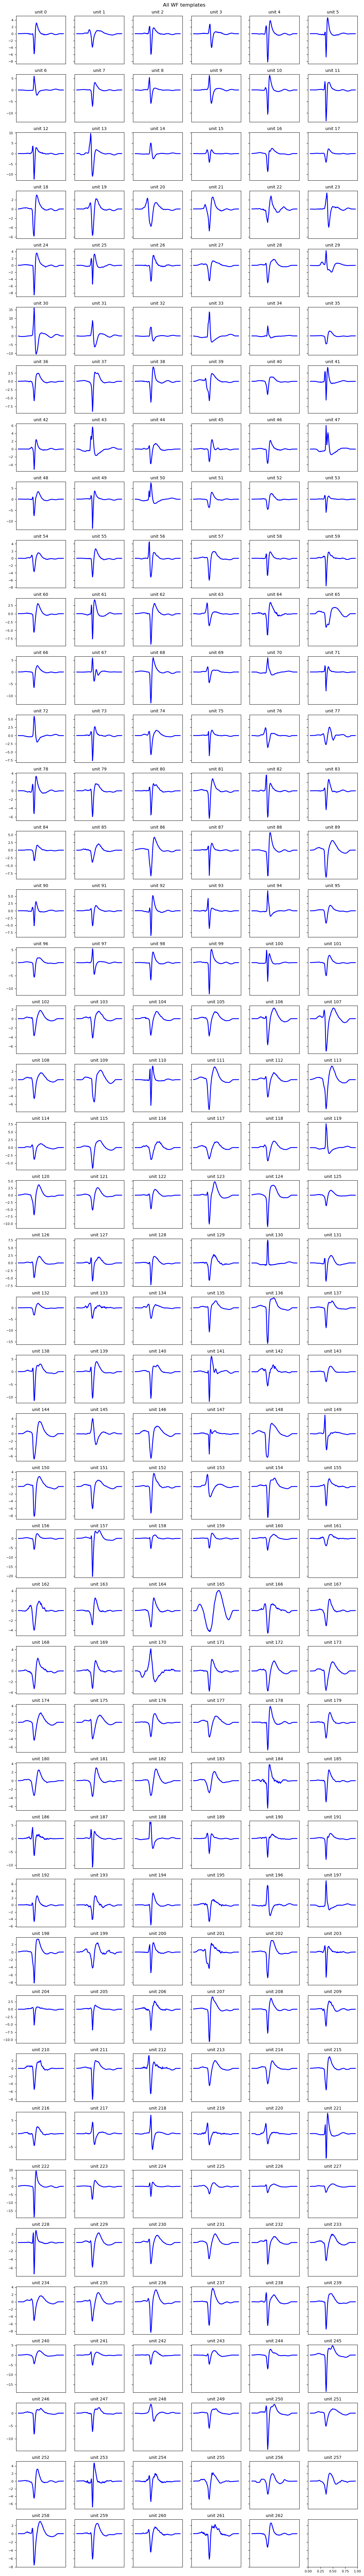

In [55]:
fig, ax = plt.subplots(math.ceil(len(dy_wfs)/6), 6, sharey='row', figsize=(12, (len(dy_wfs)/6)*2))

fig.suptitle('All WF templates')
plt.tight_layout()
# st.set_y(0.95)
fig.subplots_adjust(top=0.975)
max_chan_max = np.max(np.max(dy_wfs, axis=1))
max_chan_min = np.min(np.min(dy_wfs, axis=1))
x = np.arange(0, 121)
for i in range(math.ceil(len(dy_wfs)/6)):
    max_chan_max = np.max(np.max(dy_wfs[6*i:6*(i+1)], axis=1))
    max_chan_min = np.min(np.min(dy_wfs[6*i:6*(i+1)], axis=1))
    for j in range(6):
        idx = 6*i + j
        if idx > 440:
            break
        ax[i, j].set_ylim(max_chan_min-0.5, max_chan_max+0.5)
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].title.set_text('unit ' + str(idx))
        ax[i, j].plot(x, dy_wfs[idx], linewidth=2, markersize=12, color='blue')

In [64]:
# indices of WFs with unique shapes 
wf_interest_nyu = [0, 218, 33, 39, 11, 165, 221, 29]
wf_interest_dy = [2, 3, 9, 11, 27, 428, 118, 57]

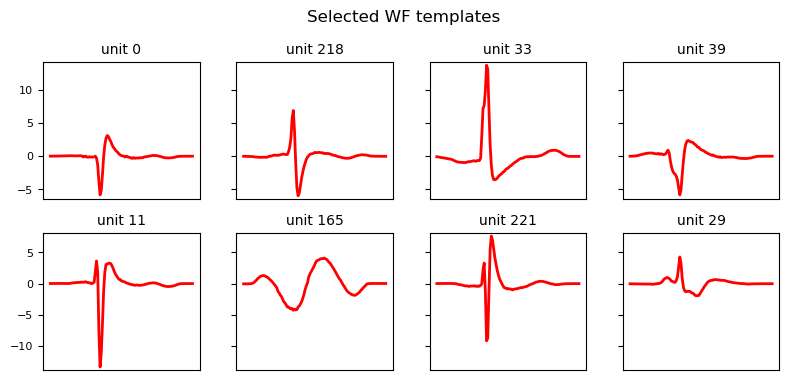

In [65]:
# Plot the interesting wf shapes
fig, ax = plt.subplots(2, 4, sharey='row', figsize=(8, 4))

fig.suptitle('Selected WF templates - DY016')
plt.tight_layout()
# st.set_y(0.95)
fig.subplots_adjust(top=0.85)
# max_chan_max = np.max(np.max(nyu_wfs, axis=1))
# max_chan_min = np.min(np.min(nyu_wfs, axis=1))
x = np.arange(0, 121)
for i in range(2):
    max_chan_max = np.max(np.max(dy_wfs[wf_interest_dy[4*i:4*(i+1)]], axis=1))
    max_chan_min = np.min(np.min(dy_wfs[wf_interest_dy[4*i:4*(i+1)]], axis=1))
    for j in range(4):
        idx = wf_interest_dy[4*i+j]
        ax[i, j].set_ylim(max_chan_min-0.5, max_chan_max+0.5)
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].title.set_text('unit ' + str(idx))
        ax[i, j].plot(x, dy_wfs[idx], linewidth=2, markersize=12, color='red')

### Get Augmentation pipeline for creating stochastically augmented dataset

In [89]:
def get_transform(temp_cov_fn, spatial_cov_fn, probs=None):
    temporal_cov = np.load(temp_cov_fn)
    spatial_cov = np.load(spatial_cov_fn)
    if probs is None:
        probs = [0.7, 0.6, 0.5, 0.3]
    """Return a set of data augmentation transformations on waveforms."""
    data_transforms = transforms.Compose([transforms.RandomApply([AmpJitter()], p=probs[0]),
                                          transforms.RandomApply([Jitter()], p=probs[1]),
                                          transforms.RandomApply([SmartNoise(temporal_cov, spatial_cov)], p=probs[2]),
                                          transforms.RandomApply([Collide()], p=probs[3]),
                                              ToWfTensor()])
    return data_transforms

# covariance matrices for noise generation
temp_cov_fn = '/Users/ankit/Documents/PaninskiLab/contrastive_spikes/nyu47_templates/temporal_cov_example.npy'
spatial_cov_fn = '/Users/ankit/Documents/PaninskiLab/contrastive_spikes/nyu47_templates/spatial_cov_example.npy'
transform_obj = get_transform(temp_cov_fn, spatial_cov_fn, probs)
tf_wfs_train = []
tf_wfs_test = []
for i, wf_idx in enumerate(wf_interest):
    curr_wf = nyu_wfs[wf_idx]
    tf_wfs_train.append([transform_obj(curr_wf).numpy() for j in range(1000)])
    tf_wfs_test.append([transform_obj(curr_wf).numpy() for j in range(200)])

tf_wfs_train = np.array(tf_wfs_train).reshape(-1, 121)
tf_wfs_test = np.array(tf_wfs_test).reshape(-1, 121)

In [91]:
# np.save('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/nyu47_templates/temps_train', tf_wfs_train)
# np.save('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/nyu47_templates/temps_test', tf_wfs_test)

In [93]:
# make dataset with 2 views for data generation
probs = [0.7, 0.7, 0.6, 0.5]
wfs = ds.get_dataset('wfs', 2)

In [94]:
print(len(wfs))

263


In [95]:
items = []
for i in range(len(wf_interest)):
    items.append(wfs[wf_interest[i]])

(24, 121)


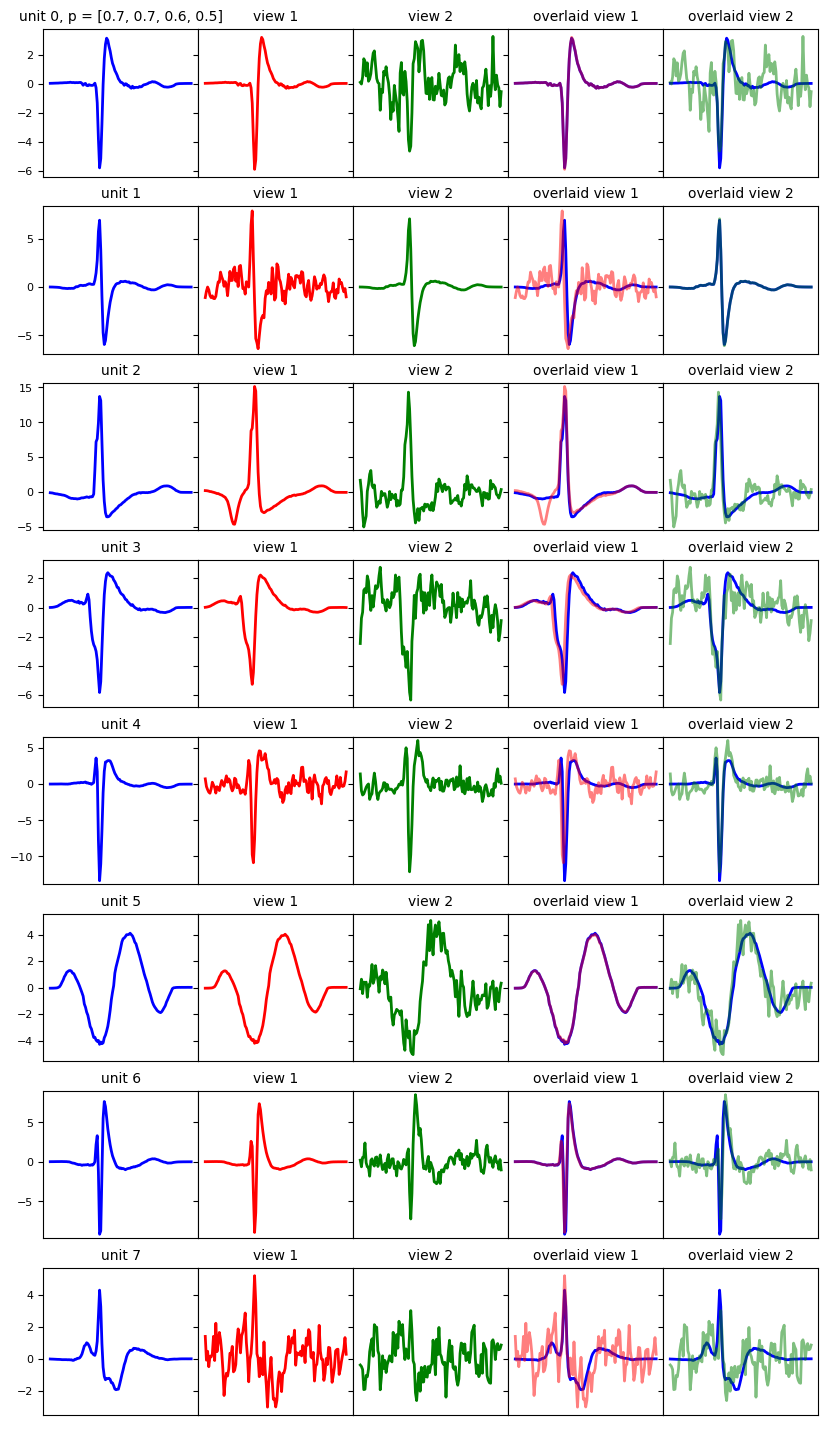

In [96]:
plot_transforms(max_chan_hptp_temps[wf_interest], np.array(items), probs)

In [ ]:
plot_spikes(dy_wfs_interest.reshape(8, 1200, -1), wf_interest_dy, dy_wfs)

### Load model checkpoints and get test set representations

In [ ]:
dy_wfs_interest = np.load('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/spikes_train.npy')
dy_wfs_test = np.load('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/spikes_test.npy')

In [25]:
# # Insert checkpoint files
# twodim_model_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/first_run/checkpoint_0300.pth.tar'
# fivedim_model_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/five_dim/checkpoint_0500.pth.tar'
# eightdim_model_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/eight_dim/checkpoint_0500.pth.tar'

# # models for og problem definition with 260 templates as instances
# two_contrastive_model = SingleChanDenoiser().load(twodim_model_path)
# five_contrastive_model = SingleChanDenoiser(out_size=5).load(fivedim_model_path)
# eight_contrastive_model = SingleChanDenoiser(out_size=8).load(eightdim_model_path)

2
5
8


In [135]:
# new problem checkpoint
# new_twodim_model_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/class_run_two/checkpoint_0300.pth.tar'
# two_contrastive_model = SingleChanDenoiser(out_size=2).load(new_twodim_model_path)

2


In [102]:
# get the contrastive reps for og problem
# og_reps, tform_reps = compute_reps(five_contrastive_model, max_chan_hptp_temps, np.array(items)[:, 0])

NameError: name 'five_contrastive_model' is not defined

In [ ]:
twodim_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/enc-1000_2d/checkpoint_1000.pth.tar'
fivedim_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/enc-1000_5d/checkpoint_1000.pth.tar'
eightdim_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/enc-1000_8d/checkpoint_1000.pth.tar'
twod_enc = Encoder(out_size=2).load(twodim_enc_path)
fived_enc = Encoder(out_size=5).load(fivedim_enc_path)
eightd_enc = Encoder(out_size=8).load(eightdim_enc_path)

In [ ]:
backbone_2d_1000 = get_backbone(twod_enc)
backbone_5d_1000 = get_backbone(fived_enc)
backbone_8d_1000 = get_backbone(eightd_enc)

In [ ]:
contr_reps_2d_1000 = compute_reps_test(backbone, dy_wfs_test)
contr_reps_5d_1000 = compute_reps_test(backbone, dy_wfs_test)
contr_reps_8d_1000 = compute_reps_test(backbone, dy_wfs_test)

In [106]:
import umap.umap_ as umap
from sklearn.decomposition import PCA

def learn_manifold_umap(data, umap_dim, umap_min_dist=0.2, umap_metric='euclidean', umap_neighbors=10):
    md = float(umap_min_dist)
    return umap.UMAP(random_state=0, metric=umap_metric, n_components=umap_dim, n_neighbors=umap_neighbors,
                    min_dist=md).fit_transform(data)

def pca(S, n_comps):
    pca_ = PCA(n_components=n_comps)
    return pca_.fit_transform(S), pca_.explained_variance_ratio_

# og_pca, og_pca_var = pca(max_chan_hptp_temps, 2)
# tform_pca, tform_var = pca(tform_temps_numpy, 2)
# og_reps_pca, og_reps_var = pca(og_reps, 2)
# tform_reps_pca, tform_reps_var = pca(tform_reps, 2)

# og_reps_umap = learn_manifold_umap(og_reps, 2)
# tform_reps_umap = learn_manifold_umap(tform_reps, 2)

In [ ]:
og_pca, og_pca_var = pca(dy_wfs_test, 2)
# contr_pca, contr_pca_var = pca(contr_reps, 2)
# contr_umap = learn_manifold_umap(contr_reps, 2)
fived_pca, fived_pca_var = pca(contr_reps_5d_1000, 2)
eightd_pca, eightd_pca_var = pca(contr_reps_8d_1000, 2)

In [107]:
og_pca, og_pca_var = pca(tf_wfs_test, 2)
# contr_pca, contr_pca_var = pca(contr_reps, 2)
# contr_umap = learn_manifold_umap(contr_reps, 2)

In [109]:
print(og_pca_var)
# print(contr_pca_var)

[0.4251873  0.18447078]


In [130]:
def plot_all_pts(og_reps, title, save_name=None):
    dim = og_reps.shape[1]
    num_axes = 2 if dim > 2 else 1

    fig = plt.figure(figsize=(num_axes*5, 5))

    ax0 = fig.add_subplot(1, num_axes, 1)
    ax0.scatter(og_reps[:, 0], og_reps[:, 1], c='blue', clip_on=False)
    # ax0.scatter(tform_reps[:, 0], tform_reps[:, 1], c='blue', clip_on=False)
    ax0.set_title('first 2 dims')
    if dim > 2:
        ax1 = fig.add_subplot(1, 2, 2, projection='3d')
        ax1.scatter(og_reps[:, 2], og_reps[:, 3], og_reps[:, 4], c='red', clip_on=False)
        # ax1.scatter(tform_reps[:, 2], tform_reps[:, 3], tform_reps[:, 4], c='red', clip_on=False)
        ax1.set_title('next 3 dims')
    plt.suptitle(title)
    plt.tight_layout()
    if save_name is not None:
        plt.savefig(save_name)
        
        
def plot_contr_v_pca(pca_reps, contr_reps, wfs, wf_interest, title=None, save_name=None):
    og_wfs = wfs[wf_interest]
    n_temps = len(pca_reps)
    lat_dim = pca_reps.shape[1]
    num_wfs = len(og_wfs)
    
    max_chan_max = np.max(np.max(og_wfs, axis=1))
    max_chan_min = np.min(np.min(og_wfs, axis=1))
    # max_chan_max = max([np.max(temp) for temp in tot_temps])
    # max_chan_min = min([np.min(temp) for temp in tot_temps])
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black', 'cyan', 'violet'][:num_wfs]
    labels = np.array([[colors[i] for j in range(200)] for i in range(num_wfs)])
    labels = labels.flatten()
    print(labels.shape)
    
    fig = plt.figure(figsize=(12, 8), constrained_layout=True)
    gs = GridSpec(4, num_wfs, figure=fig)
    
    ax0 = fig.add_subplot(gs[:3, :int(num_wfs/2)])
    ax0.title.set_text('PCA wf representations')
    ax0.scatter(pca_reps[:, 0], pca_reps[:, 1], c=labels, clip_on=False)
    
    ax1 = fig.add_subplot(gs[:3, int(num_wfs/2):])
    ax1.title.set_text('Contrastive wf representations')
    ax1.scatter(contr_reps[:, 0], contr_reps[:, 1], c=labels, clip_on=False) 
    
    axs = [fig.add_subplot(gs[3, i]) for i in range(num_wfs)]
        
    x = np.arange(0, 121)

    for i in range(num_wfs):
        # axs[0] = fig.add_subplot(gs[i//2, 2 + 2*(i%2)])
        axs[i].set_ylim(max_chan_min-0.5, max_chan_max+0.5)
        axs[i].title.set_text('unit {}'.format(str(wf_interest[i])))
        axs[i].plot(x, og_wfs[i], linewidth=2, markersize=12, color=colors[i])
        axs[i].get_xaxis().set_visible(False)
    
    # fig.subplots_adjust(wspace=0)

    fig.suptitle(title)
    
    if save_name is not None:
        plt.savefig(save_name)

(1600,)


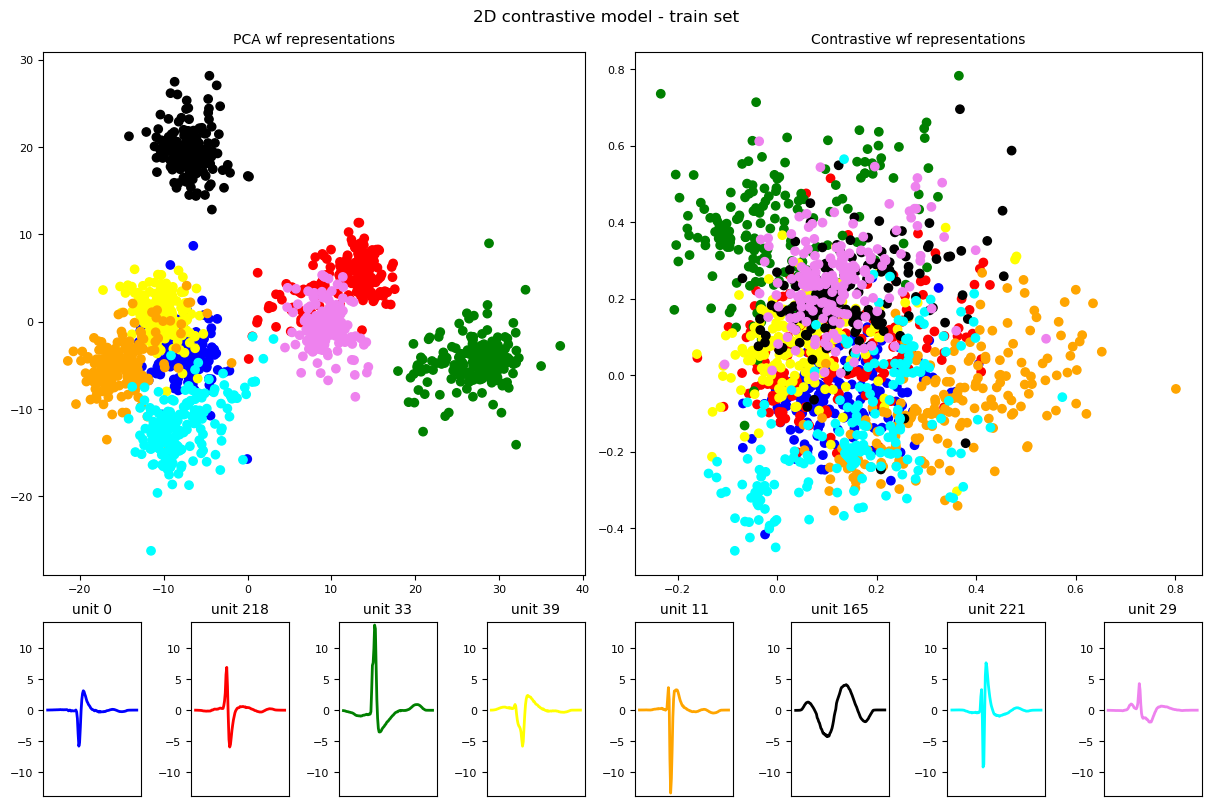

In [134]:
plot_contr_v_pca(og_pca, contr_reps, nyu_wfs, wf_interest, title='2D contrastive model - test set') 

In [ ]:
plot_contr_v_pca(og_pca, contr_reps_2d_1000, dy_wfs, wf_interest_dy, title='2D contrastive model - test set')

In [ ]:
plot_contr_v_pca(og_pca, fived_pca, dy_wfs, wf_interest_dy, title='5D contrastive model 2D PCA reps - test set') 

In [ ]:
plot_contr_v_pca(og_pca, eightd_pca, dy_wfs, wf_interest_dy, title='8D contrastive model 2D PCA reps - test set')

## Older plots from OG version of the problem (260 templates as instances)

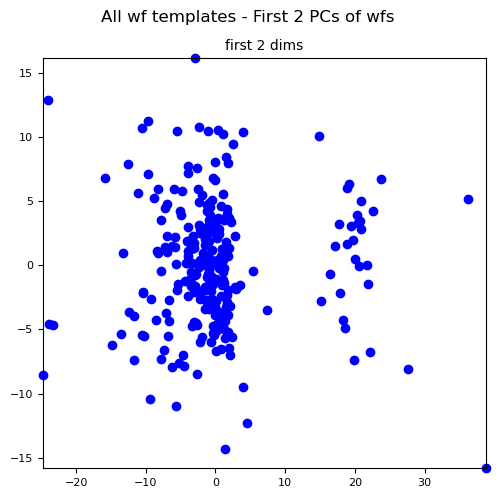

In [48]:
plot_all_pts(og_pca, 'All wf templates - First 2 PCs of wfs')

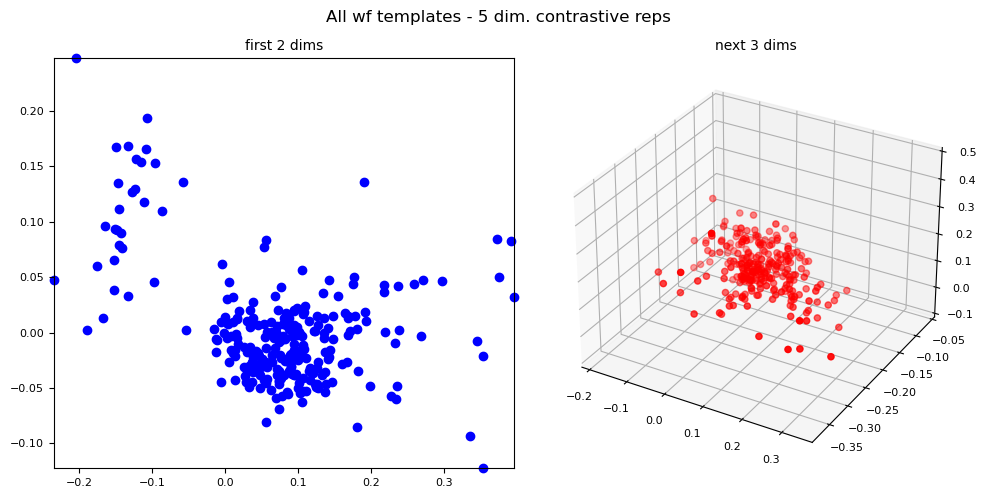

In [46]:
plot_all_pts(og_reps, 'All wf templates - 5 dim. contrastive reps')

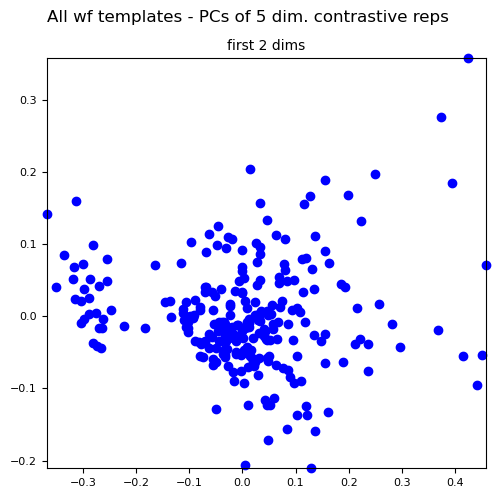

In [47]:
plot_all_pts(og_reps_pca, 'All wf templates - PCs of 5 dim. contrastive reps')

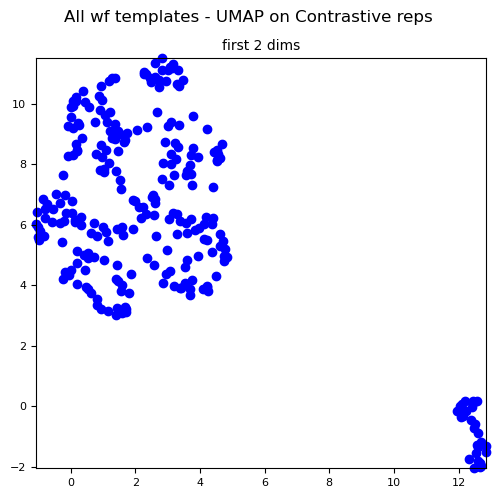

In [45]:
plot_all_pts(og_reps_umap, 'All wf templates - UMAP on Contrastive reps')

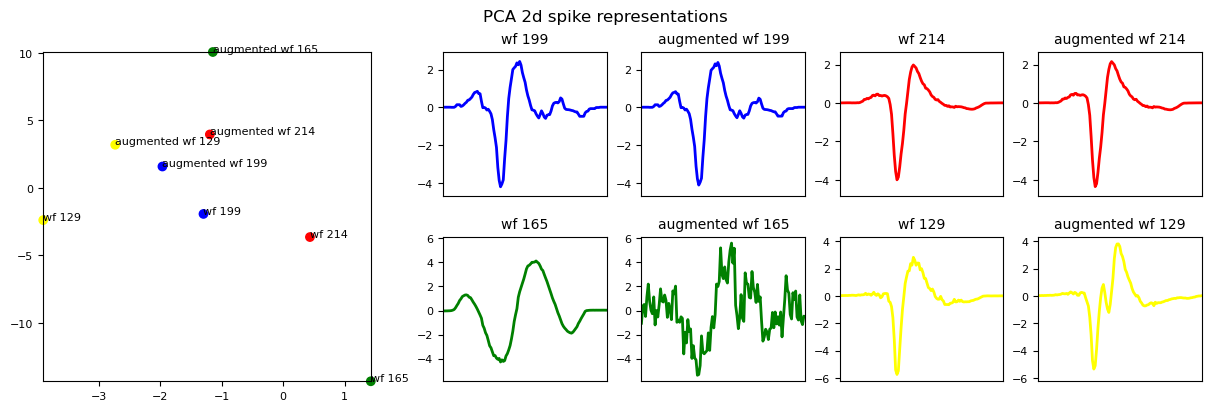

In [57]:
plot_reps(max_chan_hptp_temps, np.array(items)[:, 0], og_pca, tform_pca, 'PCA 2d spike representations')

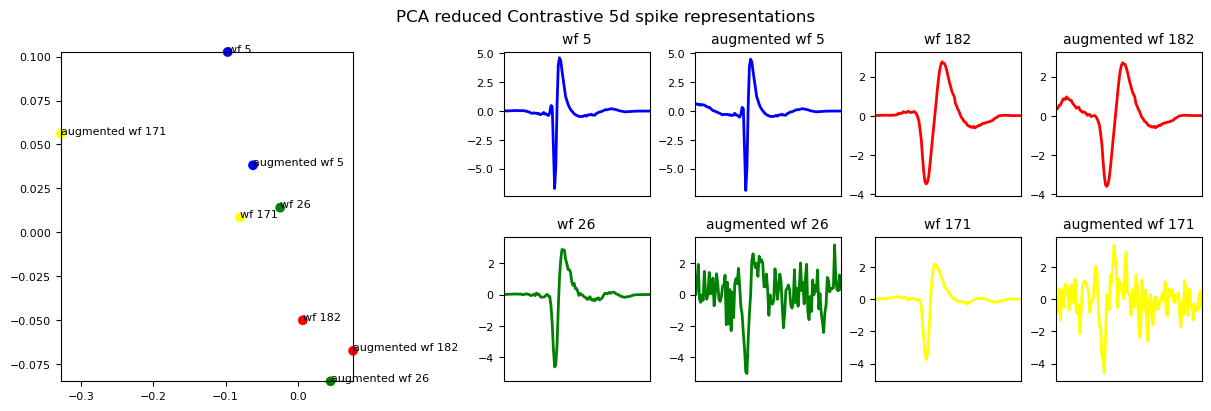

In [32]:
plot_reps(max_chan_hptp_temps, np.array(items)[:, 0], og_reps_pca, tform_reps_pca, 'PCA reduced Contrastive 5d spike representations', 'c_spk_reps_5d_pca')

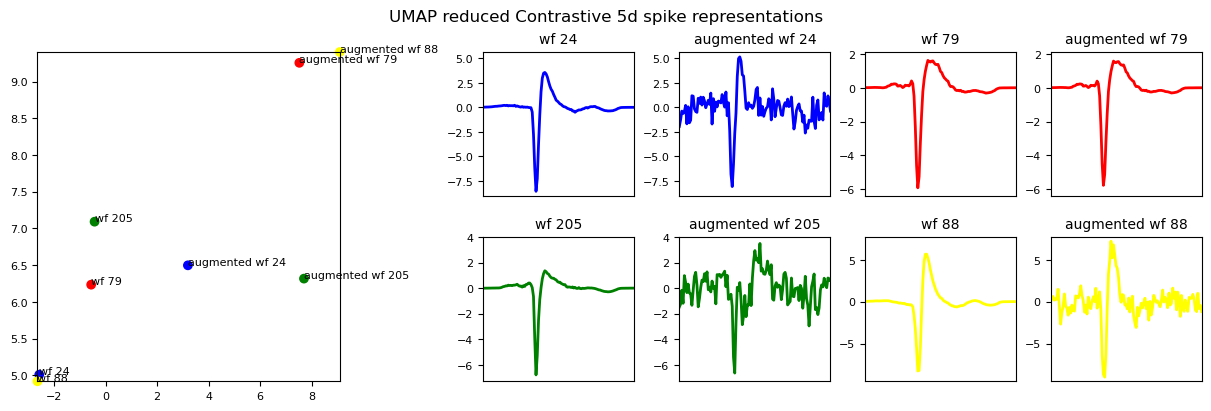

In [36]:
plot_reps(max_chan_hptp_temps, np.array(items)[:, 0], og_reps_umap, tform_reps_umap, 'UMAP reduced Contrastive 5d spike representations', 'c_spk_reps_5d_umap')

[ 0.61339627 -0.31564102]


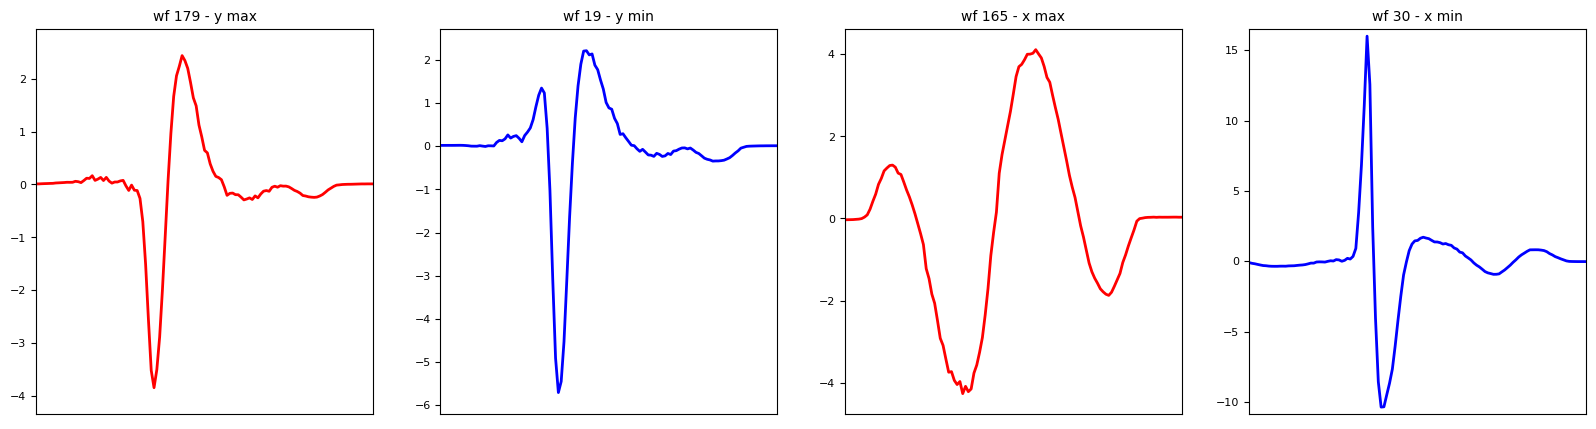

In [51]:
# Wf templates that are furthest away on each axis

y_max_idx = np.argmax(tform_reps[:, 1])
y_min_idx = np.argmin(tform_reps[:, 1])
x_max_idx = np.argmax(tform_reps[:, 0])
x_min_idx = np.argmin(tform_reps[:, 0])
print(tform_reps[x_max_idx])

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

x = np.arange(121)
ax[0].set_ylim(np.min(max_chan_hptp_temps[y_max_idx])-0.5, np.max(max_chan_hptp_temps[y_max_idx])+0.5)
ax[0].title.set_text('wf {} - y max'.format(str(y_max_idx)))
ax[0].plot(x, max_chan_hptp_temps[y_max_idx], linewidth=2, markersize=12, color='red')
ax[0].get_xaxis().set_visible(False)

ax[1].set_ylim(np.min(max_chan_hptp_temps[y_min_idx])-0.5, np.max(max_chan_hptp_temps[y_min_idx])+0.5)
ax[1].title.set_text('wf {} - y min'.format(str(y_min_idx)))
ax[1].plot(x, max_chan_hptp_temps[y_min_idx], linewidth=2, markersize=12, color='blue')
ax[1].get_xaxis().set_visible(False)

ax[2].set_ylim(np.min(max_chan_hptp_temps[x_max_idx])-0.5, np.max(max_chan_hptp_temps[x_max_idx])+0.5)
ax[2].title.set_text('wf {} - x max'.format(str(x_max_idx)))
ax[2].plot(x, max_chan_hptp_temps[x_max_idx], linewidth=2, markersize=12, color='red')
ax[2].get_xaxis().set_visible(False)

ax[3].set_ylim(np.min(max_chan_hptp_temps[x_min_idx])-0.5, np.max(max_chan_hptp_temps[x_min_idx])+0.5)
ax[3].title.set_text('wf {} - x min'.format(str(x_min_idx)))
ax[3].plot(x, max_chan_hptp_temps[x_min_idx], linewidth=2, markersize=12, color='blue')
ax[3].get_xaxis().set_visible(False)